##### TODO
- [ ] Count all objects per group

__Dependencies__

In [1]:
import copy  # copy big/deep objects by value
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import os  # OS operations (read/write files/folders)
import warnings  # hide warnings

# process parallelization
from multiprocessing import Manager, Pool, RawArray, cpu_count

import matplotlib.patches as mpatches  # create custom plot legends
import matplotlib.pyplot as plt  # mother of plots focr Python
import matplotlib.ticker as ticker  # matplotlib ticker utils
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import display, display_html  # print nicely
from matplotlib.lines import Line2D  # matplotlib custom lines
from scipy import stats  # statistical tests
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from statsmodels.multivariate.manova import MANOVA  # test results with MANOVA
from tqdm.notebook import tqdm  # mother of progressbars for Python

# from matplotlib.ticker import FormatStrFormatter  # tick formatter

__Options__

In [2]:
warnings.filterwarnings("ignore")
# set default float display format to 3 decimals
pd.options.display.float_format = "{:.3f}".format

STYLE = "whitegrid"
sns.set(rc={"figure.figsize": (20, 8)}, palette="deep")  # figure (plot) size
sns.set_style(STYLE)  # set seaborn plotting style

PATH_PROC = "./data/processed"

# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""

"""
Event1: 1162-1400
Event2: 1958-2080
Event3: 2596-2890
"""
event_ranges = [(1162, 1400), (1958, 2080), (2596, 2890)]

CONDS = ["AVAS", "RadioTalk", "TaxiDriver"]

groups = [
    "Buildings",
    "Dynamic Cars",
    "Dynamic Pedestrians",
    "Inside Car",
    "Nature",
    "Roads",
    "Static Cars",
    "Static Pedestrians",
    "Street Objects",
    "Traffic Lights",
    "Traffic Signs",
]

palette = itertools.cycle(sns.color_palette(palette="deep"))  # color palette

colors = [next(palette) for i in range(3)]

# permuatation tests custom legend components
simulated_patch = mpatches.Patch(color=colors[0], label="Simulated MD")
measured_patch = Line2D(
    [],
    [],
    marker=None,
    color="g",
    label="Measured MD",
    linestyle="-",
)
avg_patch = Line2D(
    [],
    [],
    marker=None,
    color="r",
    label="Simulated avg MD",
    linestyle="-",
)
std_patch = Line2D(
    [],
    [],
    marker=None,
    color="r",
    label="± 2std",
    linestyle="--",
)

CORES = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {CORES}")

Total CPU threads: 16


__Helper functions__

In [3]:
def normalize_series(s):
    """Normalize a series (dataframe column)."""
    # Mean normalization: (s - s.min()) / (s.max() - s.min())
    # Std normalization: (s - s.mean()) / s.std()
    return (2 * (s - s.min()) / (s.max() - s.min())) - 1  # (-1, 1) norm


def statistic(a, b):
    """
    Given two lists representing the distributions of two conditions,
    return the difference between their means.

    Parameters:
        a (list): Values of distribution A.
        b (list): Values of distribution B.
    Returns:
        (float): Difference between medians A and B.
    """
    return np.mean(a) - np.mean(b)


def permutationTest(a, b, n_perms):
    """
    Compute gaze vs rest stats and store gaze length and gaze counts (events)
    of a participant given its UID.

    Parameters:
        uid (str): Participant unique identifier.
    """

    # actual distribution test (difference between medians in this case)
    actual = statistic(a, b)

    # collect original lengths for randomization
    l_a = len(a)
    l_b = len(b)
    # concatenate values
    cmb = a + b

    stats = []
    under = 0
    for count in range(n_perms):
        # shuffle values
        rnd = np.random.permutation(cmb)
        a_rnd = rnd[:l_a]
        b_rnd = rnd[l_b:]
        # compute statistic
        stat = statistic(a_rnd, b_rnd)
        stats.append(stat)
        if stat <= actual:
            under += 1
    under_per = under * 100.0 / (count + 1)
    return actual, stats, under_per

__Read participants and questionnaires cleaned data__

In [4]:
parts = pd.read_csv("./participants_clean.csv", keep_default_na=False)
parts = parts.set_index("id")  # set uid column as index (remove default)

quests = pd.read_csv("./questionnaires.csv", keep_default_na=False)
quests = quests.set_index("id")  # set uid column as index (remove default)

conds = sorted(parts.condition.unique().tolist())

display(parts)
display(quests)

,date,expo,side,condition,nulls_%,sky_%,insidecar_%,questionnaire
id,,,,,,,,
4f583872ffed48249874b00f3d389cfc,2019-05-14 13:21:00,MSW,right,TaxiDriver,1.610,13.740,2.359,No
33d68ad55ef544fab9fd08108e3913ca,2019-05-14 16:44:00,MSW,right,AVAS,0.037,0.674,25.421,No
8598a83e2af441b8bcd0ae5d84beb875,2019-05-14 16:51:00,MSW,right,RadioTalk,0.037,33.134,0.786,No
37d7e67934974217830bb429bba7fd76,2019-05-14 16:54:00,MSW,left,AVAS,0.824,18.607,2.845,No
42bac596059749b5b8e8e83ae61de9b4,2019-05-14 16:56:00,MSW,right,TaxiDriver,0.225,26.994,0.262,No
...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,2019-12-30 15:29:00,BMBF,right,AVAS,0.300,32.160,0.000,No
611d35a7c3e940cc82495e53c2a8532d,2020-01-03 16:12:00,BMBF,right,TaxiDriver,0.674,15.462,5.054,No
3b6fda285d9e412eb081986b2f22a2e3,2020-01-03 16:13:00,BMBF,left,AVAS,1.797,3.370,11.718,No


,date,Intention,Usefulness,Ease,Trust,Gender,Age,Aviophobia,Driving,Play,VR,expo,side,condition
id,,,,,,,,,,,,,,
ec61bab6e46741969bceb80ee2246983,2019-05-26 12:06:22,50,50,50,50,intersex,25,Yes,80,58,more than 10 times,MSW,right,RadioTalk
1fbde03890d94bddaf7aa987fc732607,2019-05-26 16:02:45,100,100,100,96,Male,13,No,0,5,once,MSW,left,RadioTalk
1ad9eea672a94518b150925bac41fcbc,2019-05-26 17:23:38,17,22,0,86,Female,24,No,4,2,once,MSW,right,RadioTalk
461b2d80132f47958e50003c16084cf4,2019-05-26 17:27:34,30,70,80,80,Male,22,No,3,1,less than 10 times,MSW,right,TaxiDriver
4f300efb4a9941f7a96f57e8030b12e2,2019-05-26 17:39:25,100,100,50,50,Male,16,No,0,3,less than 10 times,MSW,right,RadioTalk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eda9175e9e1d4153ac2ca3038b2ab008,2019-12-23 09:23:08,65,30,33,20,Male,12,No,0,25,once,BMBF,right,RadioTalk
b8c9e625f07444cc8d4a0fc245bab5dd,2019-12-23 09:28:25,100,50,50,100,Female,12,Yes,99,9,less than 10 times,BMBF,right,TaxiDriver
2cd78ad9a37945de9f8cfd5f81c42082,2019-12-27 12:56:23,86,20,71,69,Male,57,No,39,0,never,BMBF,right,RadioTalk


__Null data check__

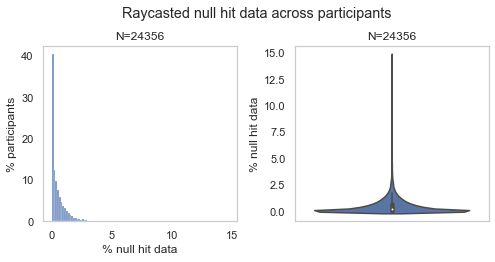

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3.5))
fig.suptitle(f"Raycasted null hit data across participants")
fig.tight_layout()

ax = sns.histplot(data=parts["nulls_%"], stat="percent", bins=100, ax=axes[0])

# ax.set_xlim(0, 5)
ax.grid(False)
ax.set_xlabel("% null hit data")
ax.set_ylabel("% participants")
ax.set_title(f"N={parts.index.size}")

ax = sns.violinplot(data=parts["nulls_%"], stat="percent", ax=axes[1])

# ax.set_ylim(-0.5, 5)
ax.grid(False)
ax.set_xticklabels([])
ax.set_ylabel("% null hit data")

ax.set_title(f"N={parts.index.size}")

plt.subplots_adjust(wspace=0.3)
plt.show()

How many participants have more than 5% of null hit data?

In [6]:
COL = "nulls_%"
parts[parts[COL] > 5].sort_values(by=[COL]).index.size

49

__Odd hit data exploration (no gazes nor rest distinction)__

,nulls_%,sky_%,insidecar_%
count,24356.000,24356.000,24356.000
mean,0.502,13.434,9.971
std,0.724,12.294,9.944
min,0.000,0.000,0.000
25%,0.000,3.070,1.498
50%,0.225,11.194,6.552
75%,0.711,20.067,16.511
max,14.714,98.839,52.864


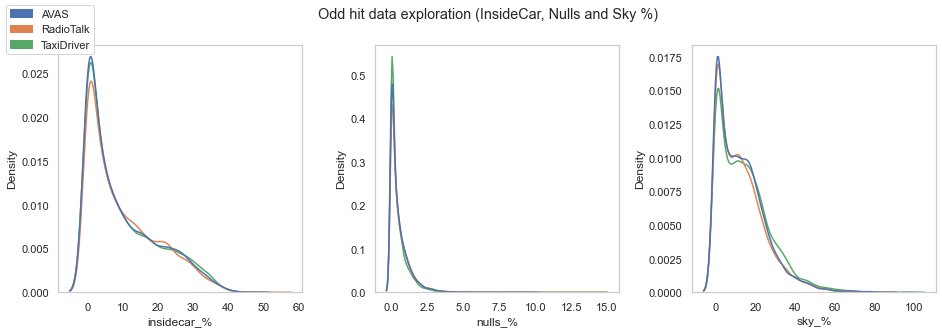

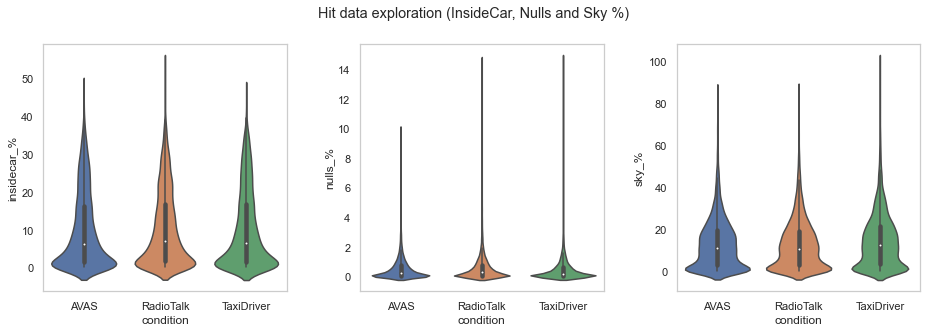

In [7]:
display(parts.describe())

fig, axes = plt.subplots(ncols=3, figsize=(13, 4.5))
fig.suptitle(f"Odd hit data exploration (InsideCar, Nulls and Sky %)")
fig.tight_layout()

cols = ["insidecar_%", "nulls_%", "sky_%"]

for i, c in enumerate(cols):
    ax = sns.kdeplot(
        data=parts,
        x=c,
        hue="condition",
        fill=False,
        common_norm=True,
        ax=axes[i],
        hue_order=CONDS,
        legend=False,
    )
    ax.grid(False)

avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
taxi_patch = mpatches.Patch(color=colors[2], label="TaxiDriver")
fig.legend(handles=[avas_patch, radio_patch, taxi_patch], loc="upper left")
plt.subplots_adjust(wspace=0.3)
plt.show()


fig, axes = plt.subplots(ncols=3, figsize=(13, 4.5))
fig.suptitle(f"Hit data exploration (InsideCar, Nulls and Sky %)")
fig.tight_layout()

cols = ["insidecar_%", "nulls_%", "sky_%"]


for i, c in enumerate(cols):
    ax = sns.violinplot(
        data=parts, x="condition", y=c, scale="area", ax=axes[i], order=CONDS
    )
    ax.grid(False)

plt.subplots_adjust(wspace=0.3)
plt.show()

__Gaze length exploration__

In [8]:
grp_len = pd.read_csv("./group_lengths.csv", index_col=0)
grp_len

,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
4f583872ffed48249874b00f3d389cfc,18.414,0.924,1.122,1.881,3.597,18.282,0.000,0.000,1.155,13.332,0.000
33d68ad55ef544fab9fd08108e3913ca,0.000,0.594,0.000,28.677,0.297,30.360,0.000,0.000,0.363,4.620,0.000
8598a83e2af441b8bcd0ae5d84beb875,38.313,0.000,0.000,0.627,0.924,0.000,0.000,0.000,0.363,9.207,0.000
37d7e67934974217830bb429bba7fd76,17.259,2.508,1.122,4.719,5.049,1.122,0.330,0.000,2.013,18.777,0.000
42bac596059749b5b8e8e83ae61de9b4,34.584,0.000,0.000,0.528,6.402,0.000,0.000,0.000,2.310,10.362,0.000
...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,34.056,0.000,0.000,6.435,2.739,0.000,0.000,0.000,1.023,8.382,0.000
611d35a7c3e940cc82495e53c2a8532d,19.041,0.000,0.000,24.288,4.686,2.838,0.000,0.000,1.056,9.174,0.363
3b6fda285d9e412eb081986b2f22a2e3,7.821,0.000,0.462,18.381,0.660,16.599,0.000,1.122,5.874,5.577,0.000
18ffb0abdc8642098c479380bfa533d1,14.718,0.264,0.000,5.478,4.950,6.402,0.000,0.000,1.485,11.418,0.627


Collect groups, include expo, side, condition and questionnaire (yes/no) columns

In [9]:
groups = grp_len.columns.tolist()
display(groups)
grp_len = grp_len.join(
    parts[["expo", "side", "condition", "questionnaire"]], how="outer"
)
display(grp_len)
display(grp_len.describe())

['Buildings',
 'Dynamic Cars',
 'Dynamic Pedestrians',
 'Inside Car',
 'Nature',
 'Roads',
 'Static Cars',
 'Static Pedestrians',
 'Street Objects',
 'Traffic Lights',
 'Traffic Signs']

,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs,expo,side,condition,questionnaire
4f583872ffed48249874b00f3d389cfc,18.414,0.924,1.122,1.881,3.597,18.282,0.000,0.000,1.155,13.332,0.000,MSW,right,TaxiDriver,No
33d68ad55ef544fab9fd08108e3913ca,0.000,0.594,0.000,28.677,0.297,30.360,0.000,0.000,0.363,4.620,0.000,MSW,right,AVAS,No
8598a83e2af441b8bcd0ae5d84beb875,38.313,0.000,0.000,0.627,0.924,0.000,0.000,0.000,0.363,9.207,0.000,MSW,right,RadioTalk,No
37d7e67934974217830bb429bba7fd76,17.259,2.508,1.122,4.719,5.049,1.122,0.330,0.000,2.013,18.777,0.000,MSW,left,AVAS,No
42bac596059749b5b8e8e83ae61de9b4,34.584,0.000,0.000,0.528,6.402,0.000,0.000,0.000,2.310,10.362,0.000,MSW,right,TaxiDriver,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,34.056,0.000,0.000,6.435,2.739,0.000,0.000,0.000,1.023,8.382,0.000,BMBF,right,AVAS,No
611d35a7c3e940cc82495e53c2a8532d,19.041,0.000,0.000,24.288,4.686,2.838,0.000,0.000,1.056,9.174,0.363,BMBF,right,TaxiDriver,No
3b6fda285d9e412eb081986b2f22a2e3,7.821,0.000,0.462,18.381,0.660,16.599,0.000,1.122,5.874,5.577,0.000,BMBF,left,AVAS,No
18ffb0abdc8642098c479380bfa533d1,14.718,0.264,0.000,5.478,4.950,6.402,0.000,0.000,1.485,11.418,0.627,BMBF,left,RadioTalk,Yes


,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
count,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000
mean,15.159,0.441,0.274,20.542,2.607,10.988,0.029,0.031,1.162,7.226,0.171
std,13.156,0.842,0.517,18.498,2.724,12.850,0.142,0.169,1.306,3.626,0.553
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2.838,0.000,0.000,5.643,0.363,1.749,0.000,0.000,0.000,4.224,0.000
50%,12.804,0.000,0.000,14.454,1.815,6.831,0.000,0.000,0.792,6.633,0.000
75%,24.816,0.561,0.396,31.779,4.026,15.312,0.000,0.000,1.749,9.471,0.000
max,59.136,9.636,9.702,88.143,21.549,82.071,3.267,4.818,15.741,24.090,7.557


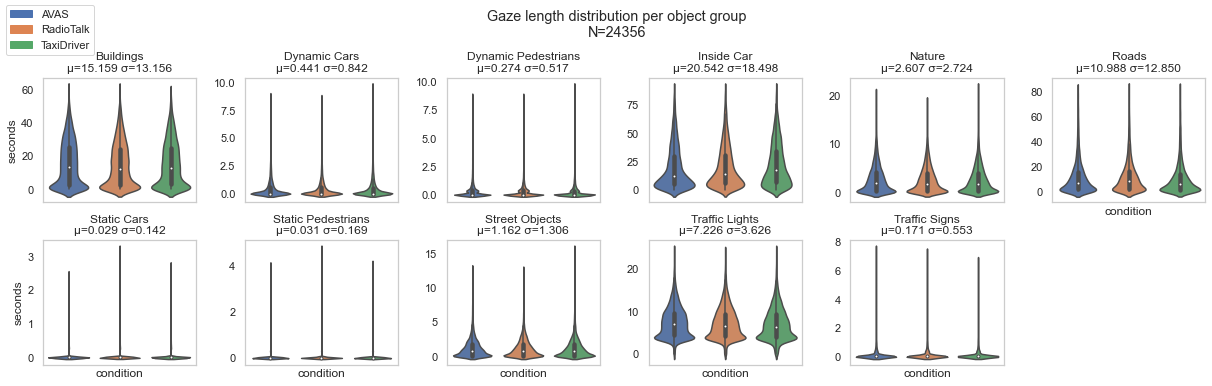

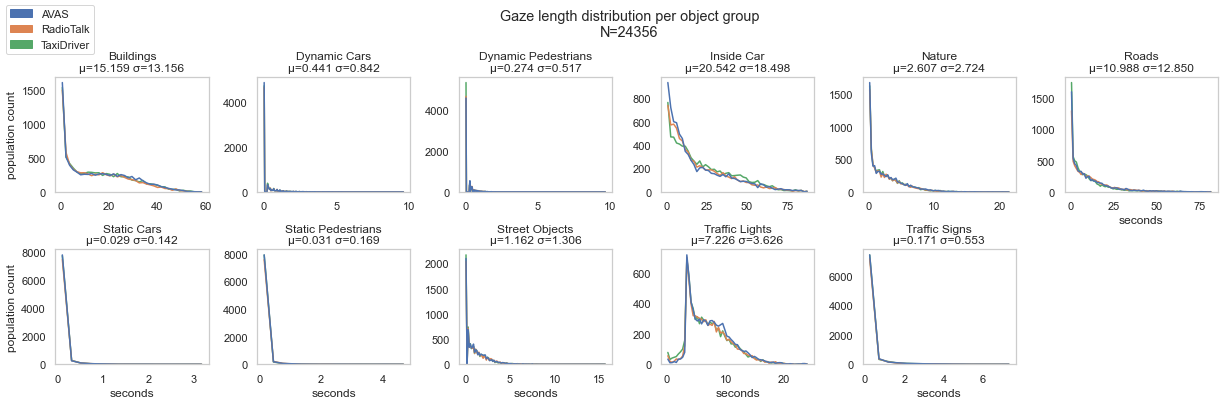

,AVAS,RadioTalk,TaxiDriver
Gaze length variance,,,
Buildings,178.100828,166.757255,173.815551
Dynamic Cars,0.744407,0.680847,0.702888
Dynamic Pedestrians,0.282181,0.254438,0.264396
Inside Car,344.805071,326.801050,349.571880
Nature,7.774340,7.092240,7.372235
Roads,172.014516,163.557646,158.338707
Static Cars,0.021912,0.018270,0.020485
Static Pedestrians,0.029236,0.027470,0.029119
Street Objects,1.735121,1.669973,1.711928


In [10]:
EXCLUDE = ["condition", "expo", "questionnaire", "side"]
groups = grp_len[grp_len.columns.difference(EXCLUDE)].columns.tolist()
conds = sorted(grp_len.condition.unique().tolist())

NROWS = 2
NCOLS = 6
N = grp_len.index.size

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(17, 5.5))
fig.suptitle(f"Gaze length distribution per object group\nN={N}\n")
fig.tight_layout()

# violin plots
r = 0
c = 0
for i, grp in enumerate(groups):
    mean = grp_len[grp].mean()
    std = grp_len[grp].std()
    title_extra = f"μ={mean:.3f} σ={std:.3f}"
    # s = normalize_series(grp_len[grp])
    ax = sns.violinplot(
        data=grp_len,
        x="condition",
        y=grp,
        hue_order=conds,
        order=conds,
        ax=axes[r, c],
    )
    ax.set_title(f"{grp}\n{title_extra}")
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.grid(False)
    if c == 0:
        ax.set_ylabel("seconds")
    if r == 1 or i == 5:
        ax.set_xlabel("condition")
    if i == 5:
        r = 1
        c = 0
    else:
        c += 1

fig.delaxes(axes[1, 5])
avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
taxi_patch = mpatches.Patch(color=colors[2], label="TaxiDriver")
fig.legend(handles=[avas_patch, radio_patch, taxi_patch], loc="upper left")
plt.subplots_adjust(hspace=0.3)
plt.show()


# histograms
NROWS = 2
NCOLS = 6
N = grp_len.index.size

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(17, 5.5))
fig.suptitle(f"Gaze length distribution per object group\nN={N}\n")
fig.tight_layout()

r = 0
c = 0
for i, grp in enumerate(groups):
    mean = grp_len[grp].mean()
    std = grp_len[grp].std()
    title_extra = f"μ={mean:.3f} σ={std:.3f}"
    # s = normalize_series(grp_len[grp])
    ax = sns.histplot(
        data=grp_len,
        hue="condition",
        x=grp,
        # kde=True,
        element="poly",
        fill=False,
        ax=axes[r, c],
        legend=False,
        hue_order=conds,
        # stat="percent",
        # log_scale=True,
    )
    # ax.set_xscale("log")
    ax.set_title(f"{grp}\n{title_extra}")
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.grid(False)
    if c == 0:
        ax.set_ylabel("population count")
    if r == 1 or i == 5:
        ax.set_xlabel("seconds")
    if i == 5:
        r = 1
        c = 0
    else:
        c += 1

fig.delaxes(axes[1, 5])
avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
taxi_patch = mpatches.Patch(color=colors[2], label="TaxiDriver")
fig.legend(handles=[avas_patch, radio_patch, taxi_patch], loc="upper left")
plt.subplots_adjust(hspace=0.5)
plt.show()

# compute variance, check for normality and homoscedasticity
cond_var = pd.DataFrame(columns=conds)
for cond in conds:
    cond_var[cond] = grp_len[grp_len.condition == cond].var()
cond_var.index.name = "Gaze length variance"

# collect and display the variance of each group between conditions
shapiro = pd.DataFrame(columns=conds)
bartlett = pd.DataFrame(columns=["p-value (Bartlett)"])
for grp in groups:
    for cnd in conds:
        shapiro.loc[grp, cnd] = stats.shapiro(
            grp_len[grp_len.condition == cnd][grp]
        )[1]
    bartlett.loc[grp] = stats.bartlett(
        grp_len[grp_len.condition == "AVAS"][grp],
        grp_len[grp_len.condition == "TaxiDriver"][grp],
        grp_len[grp_len.condition == "RadioTalk"][grp],
    )[1]
for cnd in conds:
    check = shapiro[cnd] > 0.05
    check = ["✔️" if c == True else "❌" for c in check]
    shapiro[f" {cnd} Normality"] = check
shapiro.index.name = "Normality test"


check = bartlett["p-value (Bartlett)"] > 0.05
check = ["✔️" if c == True else "❌" for c in check]
bartlett["Homoscedasticity"] = check
bartlett.index.name = "Homoscedasticity test"


tables_joint = ""
df = cond_var.style.set_table_attributes("style='display:inline'")
tables_joint += df._repr_html_()
df = bartlett.style.set_table_attributes("style='display:inline'")
tables_joint += df._repr_html_()
df = shapiro.style.set_table_attributes("style='display:inline'")
tables_joint += df._repr_html_()

display_html(tables_joint, raw=True)

Looking at the means, stds and distributions of each group, we see that we need a better groupping since some of the groups individually were barely gazed.

Also, we do not only confirm that none of the independent variables (gaze length of each object group) are non-normally distributed (Shapiro's test) in any condition (DV). But we also confirm that the variance per IV between DV is non homogeneous (homoscedasticity, using Bartlett's test), except for Street Objects and Traffic Lights IVs.
However, before looking into the data after the groupping, we want to check the differences between groups and the correlation between IVs.

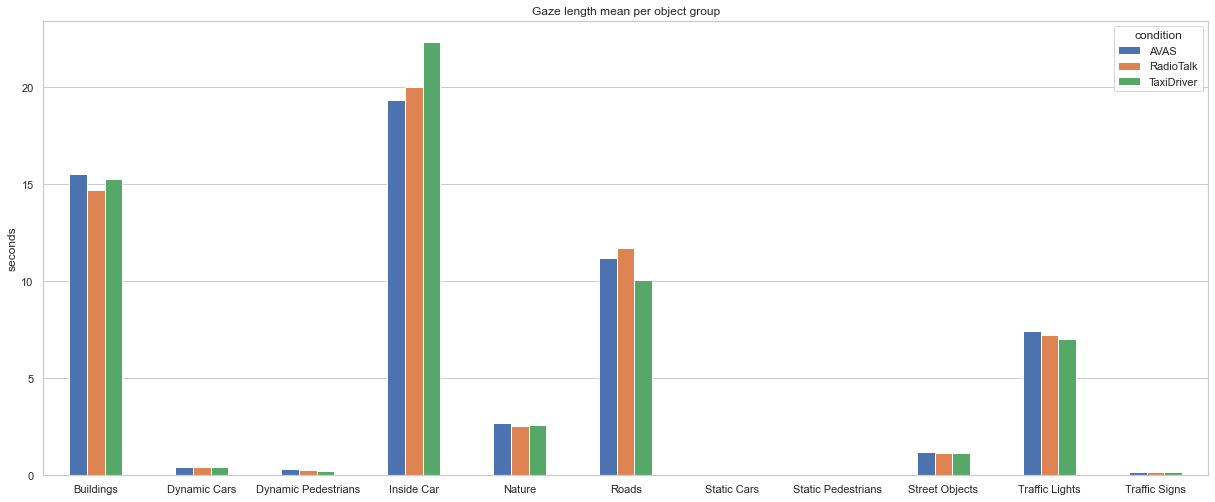

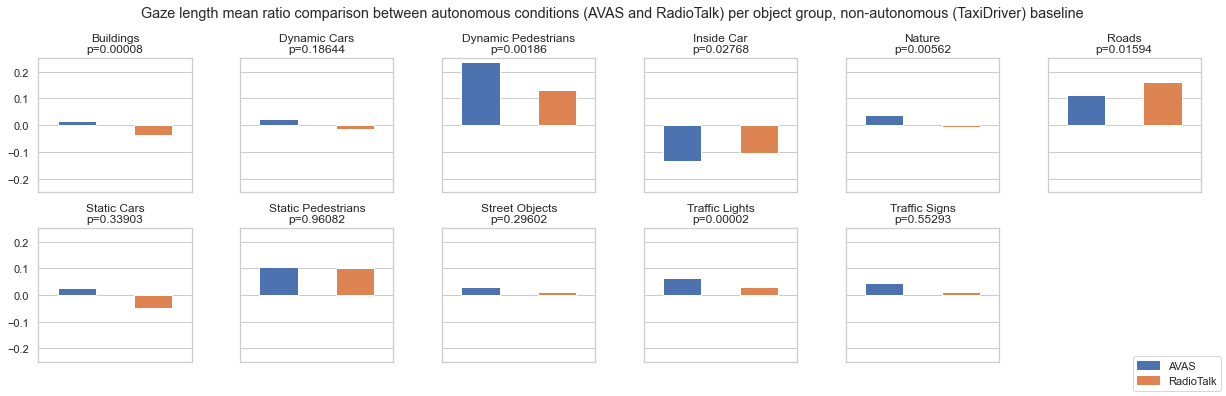

In [11]:
fig, axes = plt.subplots(figsize=(17, 7))
fig.tight_layout()

ax = grp_len.groupby(["condition"]).mean().transpose().plot.bar(rot=0, ax=axes)

ax.set_ylabel("seconds")
ax.xaxis.grid(False)

plt.title("Gaze length mean per object group")

plt.show()

NROWS = 2
NCOLS = 6

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(17, 5.5))
fig.suptitle(
    "Gaze length mean ratio comparison between autonomous conditions (AVAS and RadioTalk) per object group, non-autonomous (TaxiDriver) baseline\n"
)
fig.tight_layout()

r = 0
c = 0
for i, grp in enumerate(groups):
    means = grp_len.groupby(["condition"])[grp].mean()
    s = means / means.loc["TaxiDriver"] - 1
    s = s.loc[["AVAS", "RadioTalk"]]
    ax = s.transpose().plot.bar(rot=0, color=colors, ax=axes[r, c])
    if c != 0:
        ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel(None)
    ax.set_title(grp)
    ax.set_ylim(-0.25, 0.25)
    ax.set_xticks([])
    # calculate p-value using Welch's t-test (assuming different variance)
    avas = grp_len[grp_len.condition == "AVAS"][grp]
    radio = grp_len[grp_len.condition == "RadioTalk"][grp]
    taxi = grp_len[grp_len.condition == "TaxiDriver"][grp]
    t_test = stats.ttest_ind(avas, radio, equal_var=False)
    ax.set_title(f"{grp}\np={t_test[1]:.5f}")
    if i == 5:
        r = 1
        c = 0
    else:
        c += 1


fig.delaxes(axes[1, 5])
avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
fig.legend(handles=[avas_patch, radio_patch], loc="lower right")
plt.show()

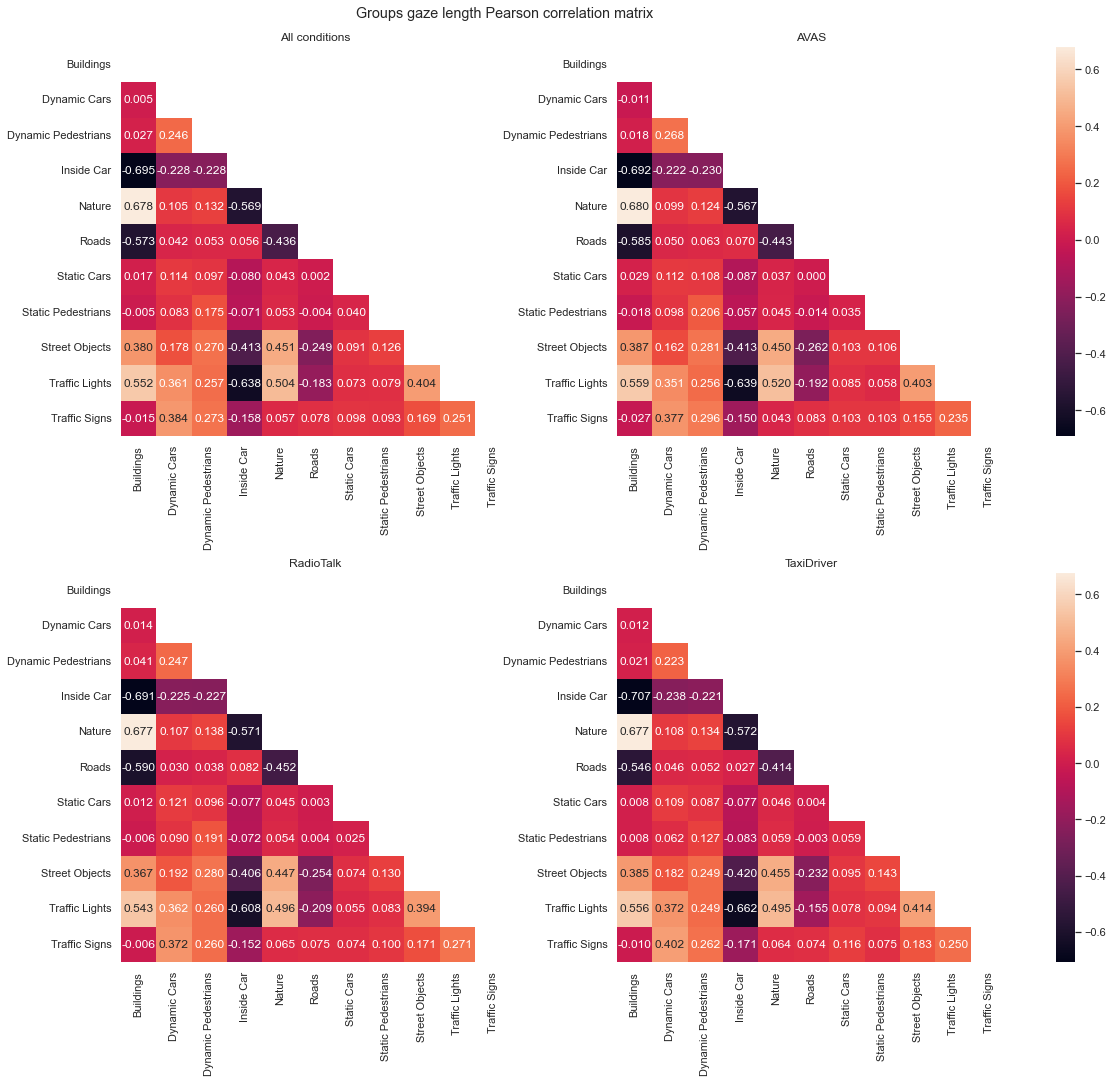

In [12]:
# participants per condition
cnds = {c: parts[parts.condition == c].index.tolist() for c in conds}

# filter out nulls
cols = grp_len.columns.difference(["nulls"])


fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 14))
fig.suptitle("Groups gaze length Pearson correlation matrix\n")
fig.tight_layout()

# compute and display a correlation matrix between groups
corr = grp_len[cols].corr(method="pearson")
# display(corr)

# generate a mask to drop the upper part of the matrix (duplicated info)
mask = np.triu(np.ones_like(corr, dtype=np.bool))

r = 0
c = 0

# display the correlation matrix as a heatmap
ax = sns.heatmap(
    corr,
    annot=True,
    mask=mask,
    ax=axes[r, c],
    cbar=False,
    square=True,
    fmt=".3f",
)
ax.tick_params("x", labelrotation=90)
ax.set_title("All conditions")

c += 1

for i, cond in enumerate(conds):
    # compute and display a correlation matrix between groups
    sel = grp_len.loc[cnds[cond]]
    corr = sel[cols].corr(method="pearson")
    # display(corr)

    # generate a mask to drop the upper part of the matrix (duplicated info)
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    cbar = c == 1
    # display the correlation matrix as a heatmap
    ax = sns.heatmap(
        corr,
        annot=True,
        mask=mask,
        ax=axes[r, c],
        cbar=cbar,
        square=True,
        fmt=".3f",
    )
    ax.tick_params("x", labelrotation=90)
    ax.set_title(cond)
    if i + 1 == 1:
        r = 1
        c = 0
    else:
        c += 1

plt.subplots_adjust(hspace=0.35, wspace=-0.6)
plt.show()

Final groups

In [13]:
final_groups = ["Buildings", "Inside Car", "Nature", "condition"]

# length
gaze_len = grp_len[final_groups]
gaze_len["Cars and Pedestrians"] = (
    grp_len["Dynamic Cars"] + grp_len["Dynamic Pedestrians"]
)
gaze_len["Roads"] = grp_len["Static Cars"] + grp_len["Roads"]
gaze_len["Street Objects"] = (
    grp_len["Street Objects"] + grp_len["Static Pedestrians"]
)
gaze_len["Traffic Signs"] = (
    grp_len["Traffic Signs"] + grp_len["Traffic Lights"]
)
# order them alphabetically
cols = sorted(gaze_len.columns.tolist())
gaze_len = gaze_len.reindex(columns=cols)

# TR vs non-TR
gaze_ltr = pd.DataFrame(columns=["TR", "non-TR"])
gaze_ltr["TR"] = (
    gaze_len["Cars and Pedestrians"]
    + gaze_len["Roads"]
    + gaze_len["Traffic Signs"]
    + gaze_len["Inside Car"]
)
gaze_ltr["non-TR"] = (
    gaze_len["Buildings"] + gaze_len["Nature"] + gaze_len["Street Objects"]
)
gaze_ltr["condition"] = gaze_len["condition"]
# order them alphabetically
cols = sorted(gaze_ltr.columns.tolist())
gaze_ltr = gaze_ltr.reindex(columns=cols)

gaze_desc = pd.merge(
    gaze_len.describe(), gaze_ltr.describe(), left_index=True, right_index=True
)
display(gaze_desc)

,Buildings,Cars and Pedestrians,Inside Car,Nature,Roads,Street Objects,Traffic Signs,TR,non-TR
count,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000
mean,15.159,0.715,20.542,2.607,11.017,1.193,7.396,39.670,18.959
std,13.156,1.092,18.498,2.724,12.851,1.338,3.803,20.934,15.722
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.102,0.000
25%,2.838,0.000,5.643,0.363,1.782,0.000,4.290,20.823,4.282
50%,12.804,0.297,14.454,1.815,6.864,0.825,6.765,36.366,16.599
75%,24.816,0.957,31.779,4.026,15.345,1.815,9.669,57.255,30.756
max,59.136,11.187,88.143,21.549,82.071,16.401,27.918,88.143,66.099


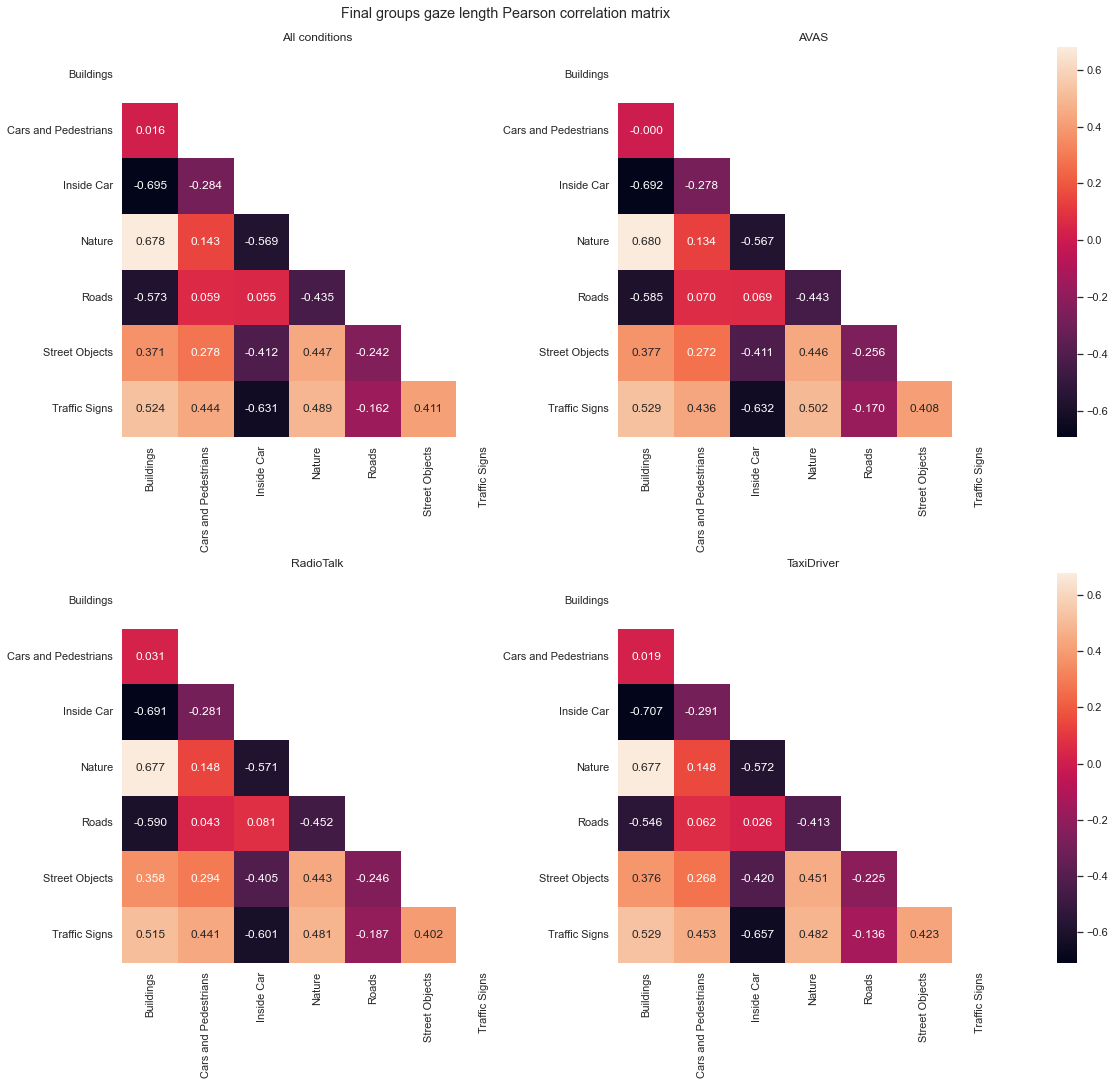

In [14]:
# participants per condition
cnds = {c: parts[parts.condition == c].index.tolist() for c in conds}
groups = gaze_len.describe().columns.tolist()

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 14))
fig.suptitle("Final groups gaze length Pearson correlation matrix\n")
fig.tight_layout()

# compute and display a correlation matrix between groups
corr = gaze_len[groups].corr(method="pearson")
# display(corr)

# generate a mask to drop the upper part of the matrix (duplicated info)
mask = np.triu(np.ones_like(corr, dtype=np.bool))

r = 0
c = 0

# display the correlation matrix as a heatmap
ax = sns.heatmap(
    corr,
    annot=True,
    mask=mask,
    ax=axes[r, c],
    cbar=False,
    square=True,
    fmt=".3f",
)
ax.tick_params("x", labelrotation=90)
ax.set_title("All conditions")

c += 1

for i, cond in enumerate(conds):
    # compute and display a correlation matrix between groups
    sel = gaze_len.loc[cnds[cond]]
    corr = sel[groups].corr(method="pearson")
    # display(corr)

    # generate a mask to drop the upper part of the matrix (duplicated info)
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    cbar = c == 1
    # display the correlation matrix as a heatmap
    ax = sns.heatmap(
        corr,
        annot=True,
        mask=mask,
        ax=axes[r, c],
        cbar=cbar,
        square=True,
        fmt=".3f",
    )
    ax.tick_params("x", labelrotation=90)
    ax.set_title(cond)
    if i + 1 == 1:
        r = 1
        c = 0
    else:
        c += 1

plt.subplots_adjust(hspace=0.35, wspace=-0.6)
plt.show()

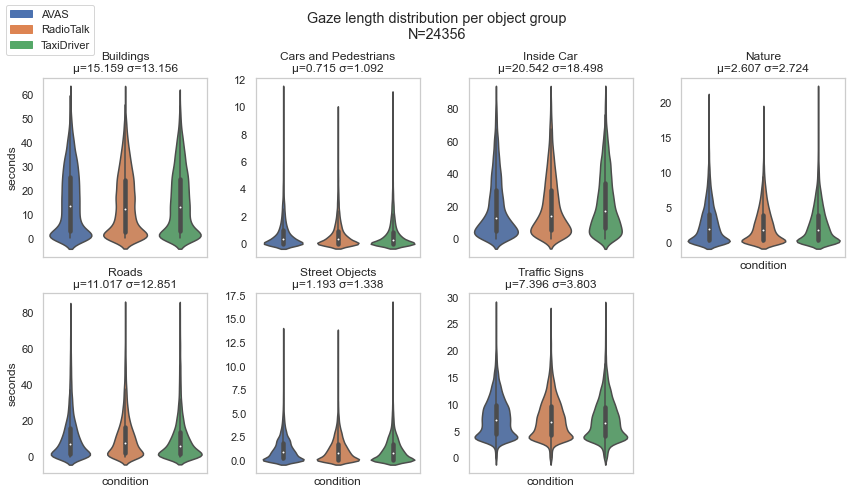

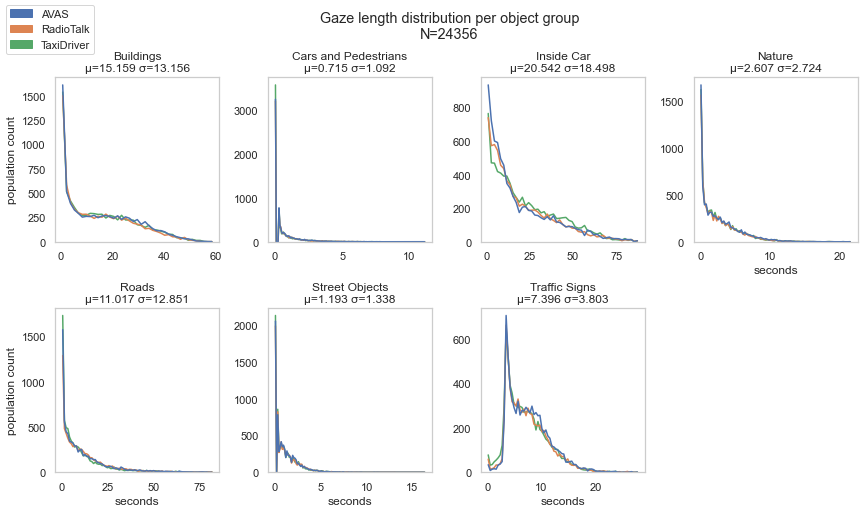

AVAS 
 RadioTalk 
 TaxiDriver 
 
 
 Gaze length variance 
   
   
   
 
 
 
 
 Buildings 
 178.100828 
 166.757255 
 173.815551 
 
 
 Cars and Pedestrians 
 1.271995 
 1.141149 
 1.159189 
 
 
 Inside Car 
 344.805071 
 326.801050 
 349.571880 
 
 
 Nature 
 7.774340 
 7.092240 
 7.372235 
 
 
 Roads 
 172.036971 
 163.586421 
 158.373044 
 
 
 Street Objects 
 1.812238 
 1.753266 
 1.804942 
 
 
 Traffic Signs 
 14.385277 
 14.302716 
 14.600052 
 
 
 

 
 
 
   
 AVAS 
 RadioTalk 
 TaxiDriver 
 AVAS Normality 
 RadioTalk Normality 
 TaxiDriver Normality 
 
 
 Normality test 
   
   
   
   
   
   
 
 
 
 
 Buildings 
 0.000000 
 0.000000 
 0.000000 
 ❌ 
 ❌ 
 ❌ 
 
 
 Cars and Pedestrians 
 0.000000 
 0.000000 
 0.000000 
 ❌ 
 ❌ 
 ❌ 
 
 
 Inside Car 
 0.000000 
 0.000000 
 0.000000 
 ❌ 
 ❌ 
 ❌ 
 
 
 Nature 
 0.000000 
 0.000000 
 0.000000 
 ❌ 
 ❌ 
 ❌ 
 
 
 Roads 
 0.000000 
 0.000000 
 0.000000 
 ❌ 
 ❌ 
 ❌ 
 
 
 Street Objects 
 0.000000 
 0.000000 
 0.000000 
 ❌ 
 ❌ 
 ❌ 
 
 
 Traffic Signs 
 0.000000 
 0.000000 
 0.000000 
 ❌ 
 ❌ 
 ❌ 
 
 
 

 
 
 
   
 p-value (Bartlett) 
 Homoscedasticity 
 
 
 Homoscedasticity test 
   
   
 
 
 
 
 Buildings 
 0.011782 
 ❌ 
 
 
 Cars and Pedestrians 
 0.000001 
 ❌ 
 
 
 Inside Car 
 0.006450 
 ❌ 
 
 
 Nature 
 0.000181 
 ❌ 
 
 
 Roads 
 0.000770 
 ❌ 
 
 
 Street Objects 
 0.272279 
 ✔️ 
 
 
 Traffic Signs 
 0.633265 
 ✔️

In [15]:
groups = gaze_len[gaze_len.columns.difference(["condition"])].columns.tolist()
conds = sorted(gaze_len.condition.unique().tolist())

# violin plots
NROWS = 2
NCOLS = 4
N = gaze_len.index.size

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(12, 7))
fig.suptitle(f"Gaze length distribution per object group\nN={N}\n")
fig.tight_layout()

r = 0
c = 0
for i, grp in enumerate(groups):
    mean = gaze_len[grp].mean()
    std = gaze_len[grp].std()
    title_extra = f"μ={mean:.3f} σ={std:.3f}"
    ax = sns.violinplot(
        data=gaze_len,
        x="condition",
        y=grp,
        hue_order=conds,
        order=conds,
        ax=axes[r, c],
    )
    ax.set_title(f"{grp}\n{title_extra}")
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.grid(False)
    if c == 0:
        ax.set_ylabel("seconds")
    if r == 1 or i == 3:
        ax.set_xlabel("condition")
    if i == 3:
        r = 1
        c = 0
    else:
        c += 1

fig.delaxes(axes[1, 3])
avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
taxi_patch = mpatches.Patch(color=colors[2], label="TaxiDriver")
fig.legend(handles=[avas_patch, radio_patch, taxi_patch], loc="upper left")
plt.show()

# histograms
fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(12, 7))
fig.suptitle(f"Gaze length distribution per object group\nN={N}\n")
fig.tight_layout()

r = 0
c = 0
for i, grp in enumerate(groups):
    mean = gaze_len[grp].mean()
    std = gaze_len[grp].std()
    title_extra = f"μ={mean:.3f} σ={std:.3f}"
    # s = normalize_series(gaze_len[grp])
    ax = sns.histplot(
        data=gaze_len,
        hue="condition",
        x=grp,
        # kde=True,
        # multiple="stack",
        element="poly",
        fill=False,
        ax=axes[r, c],
        legend=False,
        hue_order=conds,
        # stat="percent",
        # log_scale=True,
    )
    # ax.set_xscale("log")
    ax.set_title(f"{grp}\n{title_extra}")
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.grid(False)
    if c == 0:
        ax.set_ylabel("population count")
    if r == 1 or i == 3:
        ax.set_xlabel("seconds")
    if i == 3:
        r = 1
        c = 0
    else:
        c += 1

fig.delaxes(axes[1, 3])
avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
taxi_patch = mpatches.Patch(color=colors[2], label="TaxiDriver")
fig.legend(handles=[avas_patch, radio_patch, taxi_patch], loc="upper left")
plt.subplots_adjust(hspace=0.4)
plt.show()

# compute variance, check for normality and homoscedasticity
cond_var = pd.DataFrame(columns=conds)
for cond in conds:
    cond_var[cond] = gaze_len[gaze_len.condition == cond].var()
cond_var.index.name = "Gaze length variance"

# collect and display the variance of each group between conditions
shapiro = pd.DataFrame(columns=conds)
bartlett = pd.DataFrame(columns=["p-value (Bartlett)"])
for grp in groups:
    for cnd in conds:
        shapiro.loc[grp, cnd] = stats.shapiro(
            gaze_len[gaze_len.condition == cnd][grp]
        )[1]
    bartlett.loc[grp] = stats.bartlett(
        gaze_len[gaze_len.condition == "AVAS"][grp],
        gaze_len[gaze_len.condition == "TaxiDriver"][grp],
        gaze_len[gaze_len.condition == "RadioTalk"][grp],
    )[1]
for cnd in conds:
    check = shapiro[cnd] > 0.05
    check = ["✔️" if c == True else "❌" for c in check]
    shapiro[f" {cnd} Normality"] = check
shapiro.index.name = "Normality test"


check = bartlett["p-value (Bartlett)"] > 0.05
check = ["✔️" if c == True else "❌" for c in check]
bartlett["Homoscedasticity"] = check
bartlett.index.name = "Homoscedasticity test"


tables_joint = ""
df = cond_var.style.set_table_attributes("style='display:inline'")
tables_joint += df._repr_html_()
df = shapiro.style.set_table_attributes("style='display:inline'")
tables_joint += df._repr_html_()
df = bartlett.style.set_table_attributes("style='display:inline'")
tables_joint += df._repr_html_()

display_html(tables_joint, raw=True)

Looking at the means, stds and distributions of each group, we see that we need a better groupping since some of the groups individually were barely gazed.

Also, we do not only confirm that none of the independent variables (gaze length of each object group) are non-normally distributed (Shapiro's test) in any condition (DV). But we also confirm that the variance per IV between DV is non homogeneous (homoscedasticity, using Bartlett's test), except for Street Objects and Traffic Signs IVs.

__Differences between autonomous conditions (AVAS vs RadioTalk)__

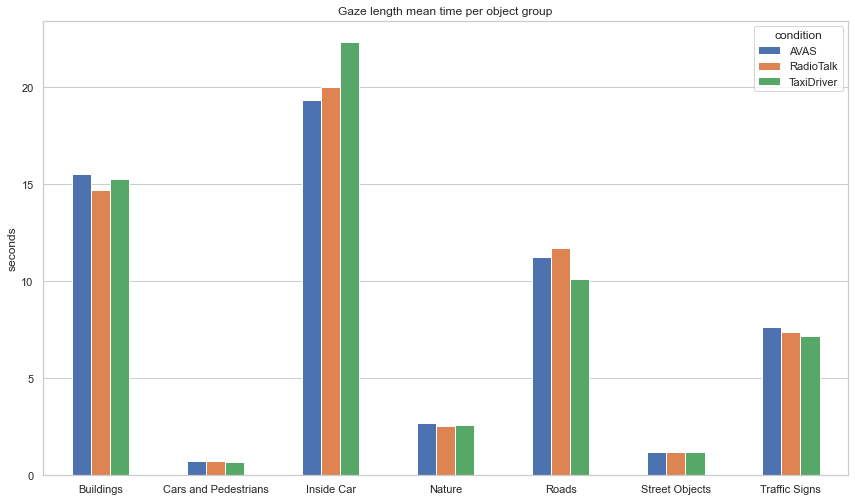

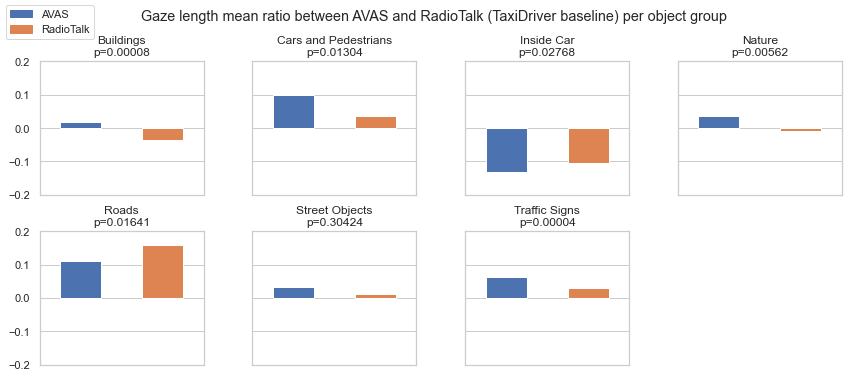

📄 0 of 7 📂 groups processed:                                                                                  …

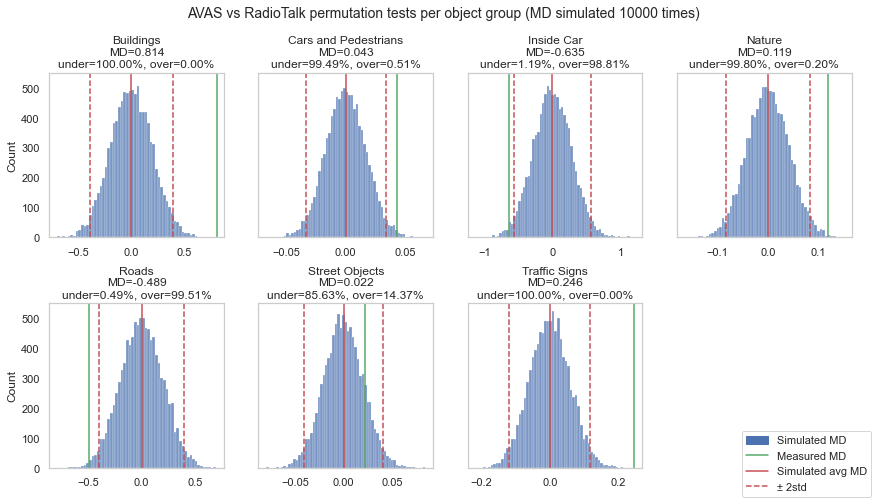

In [16]:
fig, axes = plt.subplots(figsize=(12, 7))
fig.tight_layout()

ax = (
    gaze_len.groupby(["condition"]).mean().transpose().plot.bar(rot=0, ax=axes)
)

ax.set_ylabel("seconds")
ax.xaxis.grid(False)

plt.title("Gaze length mean time per object group")

plt.show()

NROWS = 2
NCOLS = 4

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(12, 5.5))
fig.suptitle(
    "Gaze length mean ratio between AVAS and RadioTalk (TaxiDriver baseline) per object group\n"
)
fig.tight_layout()

r = 0
c = 0
for i, grp in enumerate(groups):
    means = gaze_len.groupby(["condition"])[grp].mean()
    s = means / means.loc["TaxiDriver"] - 1
    s = s.loc[["AVAS", "RadioTalk"]]
    ax = s.transpose().plot.bar(rot=0, color=colors, ax=axes[r, c])
    if c != 0:
        ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel(None)
    ax.set_title(grp)
    ax.set_ylim(-0.2, 0.2)
    ax.set_xticks([])
    # calculate p-value using Welch's t-test (assuming different variance)
    avas = gaze_len[gaze_len.condition == "AVAS"][grp]
    radio = gaze_len[gaze_len.condition == "RadioTalk"][grp]
    taxi = gaze_len[gaze_len.condition == "TaxiDriver"][grp]
    t_test = stats.ttest_ind(avas, radio, equal_var=False)
    ax.set_title(f"{grp}\np={t_test[1]:.5f}")
    if i == 3:
        r = 1
        c = 0
    else:
        c += 1


fig.delaxes(axes[1, 3])
avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
fig.legend(handles=[avas_patch, radio_patch], loc="upper left")
plt.show()

# permutation tests
groups = gaze_len.columns.difference(["condition"]).tolist()

# collect conditions indices
avas_idx = gaze_len[gaze_len.condition == "AVAS"].index.tolist()
radio_idx = gaze_len[gaze_len.condition == "RadioTalk"].index.tolist()

# participants progress bar
grps_pbar = tqdm(
    iterable=groups,
    total=len(groups),
    desc="📂 groups",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
    leave=False,
)

NROWS = 2
NCOLS = 4

N_PERMS = 10000

fig, axes = plt.subplots(NROWS, NCOLS, sharey=True, figsize=(12, 7))
fig.suptitle(
    f"AVAS vs RadioTalk permutation tests per object group (MD simulated {N_PERMS} times)\n\n",
    fontsize=14,
)
fig.tight_layout()

r = 0
c = 0
for i, g in enumerate(grps_pbar):
    # select group to test
    sel = gaze_len[g]
    # select values of each condition
    avas = sel.loc[avas_idx].values.tolist()
    radio = sel.loc[radio_idx].values.tolist()
    # do the permutation tests
    actual, stat, under = permutationTest(avas, radio, N_PERMS)
    # prepare title, compute mean and std
    title = (
        f"{g}\nMD={actual:.3f}\nunder={under:.2f}%, over={100.0 - under:.2f}%"
    )
    std = np.std(stat)
    mean = np.mean(stat)
    # plot results
    ax = sns.histplot(data=stat, ax=axes[r, c], stat="count")
    ax.set_title(title)
    ax.grid(False)
    axes[r, c].axvline(actual, color="g")
    axes[r, c].axvline(mean, color="r")
    axes[r, c].axvline(mean - 2 * std, linestyle="--", color="r")
    axes[r, c].axvline(mean + 2 * std, linestyle="--", color="r")
    if i == 3:
        r = 1
        c = 0
    else:
        c += 1

fig.delaxes(axes[1, 3])
fig.legend(
    handles=[simulated_patch, measured_patch, avg_patch, std_patch],
    loc="lower right",
)
plt.subplots_adjust(hspace=0.4)
plt.show()

__Differences between autonomous and non-autonomous (AVAS + RadioTalk vs TaxiDriver)__

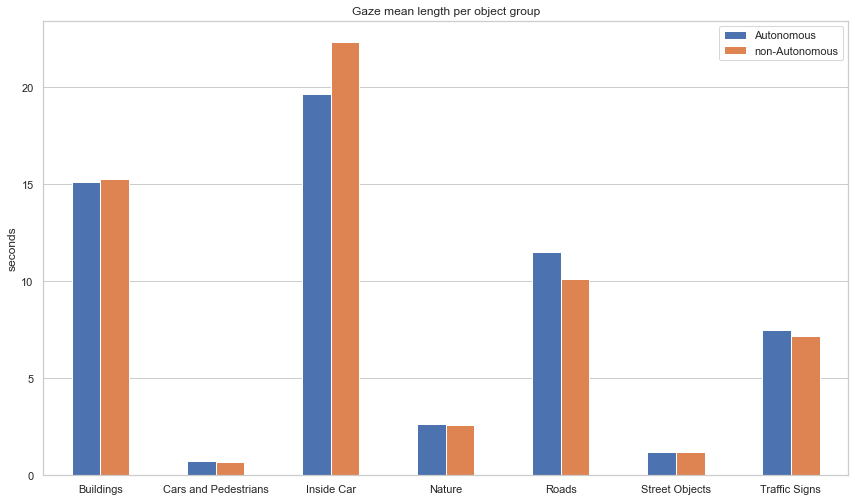

📄 0 of 7 📂 groups processed:                                                                                  …

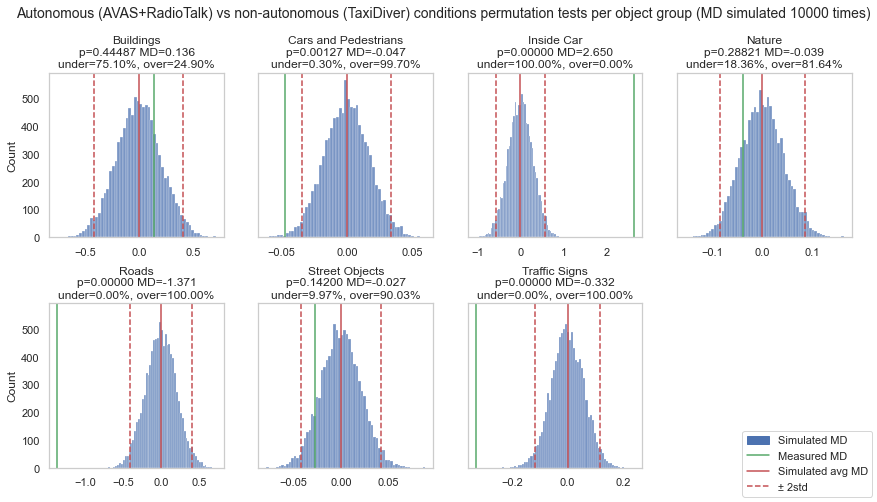

In [17]:
fig, axes = plt.subplots(figsize=(12, 7))
fig.tight_layout()

means = gaze_len.groupby(["condition"]).mean()

df = pd.DataFrame()
df["non-Autonomous"] = means.loc["TaxiDriver"]
df["Autonomous"] = (means.loc["AVAS"] + means.loc["RadioTalk"]) / 2

# order cols alphabetically
cols = sorted(df.columns.tolist())
df = df.reindex(columns=cols)

ax = df.plot.bar(rot=0, ax=axes)

ax.set_ylabel("seconds")
ax.xaxis.grid(False)

plt.title("Gaze mean length per object group")

plt.show()


# permutation tests
groups = gaze_len.columns.difference(["condition"]).tolist()

# collect conditions indices
avas_idx = gaze_len[gaze_len.condition == "AVAS"].index.tolist()
radio_idx = gaze_len[gaze_len.condition == "RadioTalk"].index.tolist()
taxi_idx = gaze_len[gaze_len.condition == "TaxiDriver"].index.tolist()

# participants progress bar
grps_pbar = tqdm(
    iterable=groups,
    total=len(groups),
    desc="📂 groups",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
    leave=False,
)

NROWS = 2
NCOLS = 4

N_PERMS = 10000

fig, axes = plt.subplots(NROWS, NCOLS, sharey=True, figsize=(12, 7))
fig.suptitle(
    f"Autonomous (AVAS+RadioTalk) vs non-autonomous (TaxiDiver) conditions permutation tests per object group (MD simulated {N_PERMS} times)\n\n",
    fontsize=14,
)
fig.tight_layout()

r = 0
c = 0
for i, g in enumerate(grps_pbar):
    # select group to test
    sel = gaze_len[g]
    # select values of each condition
    avas = sel.loc[avas_idx].values.tolist()
    radio = sel.loc[radio_idx].values.tolist()
    taxi = sel.loc[taxi_idx].values.tolist()
    # combine avas + radio (autonomous conditions)
    autonomous = avas + radio
    # do the permutation tests
    actual, stat, under = permutationTest(taxi, autonomous, N_PERMS)
    # calculate p-value using Welch's t-test (assuming different variance)
    autonomous = gaze_len[
        (gaze_len.condition == "AVAS") | (gaze_len.condition == "RadioTalk")
    ][g]
    taxi = gaze_len[gaze_len.condition == "TaxiDriver"][g]
    # autonomous.index.size
    t_test = stats.ttest_ind(autonomous, taxi, equal_var=False)
    # prepare title, compute mean and std
    title = f"{g}\np={t_test[1]:.5f} MD={actual:.3f}\nunder={under:.2f}%, over={100.0 - under:.2f}%"
    std = np.std(stat)
    mean = np.mean(stat)
    # plot results
    ax = sns.histplot(data=stat, ax=axes[r, c], stat="count")
    ax.set_title(title)
    ax.grid(False)
    axes[r, c].axvline(actual, color="g")
    axes[r, c].axvline(mean, color="r")
    axes[r, c].axvline(mean - 2 * std, linestyle="--", color="r")
    axes[r, c].axvline(mean + 2 * std, linestyle="--", color="r")
    if i == 3:
        r = 1
        c = 0
    else:
        c += 1

fig.delaxes(axes[1, 3])
fig.legend(
    handles=[simulated_patch, measured_patch, avg_patch, std_patch],
    loc="lower right",
)
plt.subplots_adjust(hspace=0.4)
plt.show()

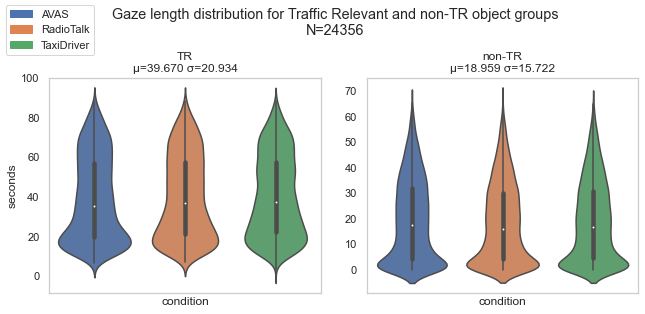

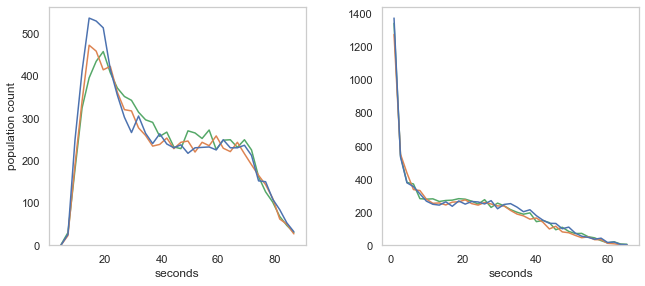

AVAS 
 RadioTalk 
 TaxiDriver 
 
 
 Gaze length variance 
   
   
   
 
 
 
 
 TR 
 454.130625 
 436.853768 
 422.752109 
 
 
 non-TR 
 255.157006 
 237.510643 
 248.075275 
 
 
 

 
 
 
   
 p-value (Bartlett) 
 Homoscedasticity 
 
 
 Homoscedasticity test 
   
   
 
 
 
 
 TR 
 0.005061 
 ❌ 
 
 
 non-TR 
 0.005333 
 ❌ 
 
 
 

 
 
 
   
 AVAS 
 RadioTalk 
 TaxiDriver 
 AVAS Normality 
 RadioTalk Normality 
 TaxiDriver Normality 
 
 
 Normality test 
   
   
   
   
   
   
 
 
 
 
 TR 
 0.000000 
 0.000000 
 0.000000 
 ❌ 
 ❌ 
 ❌ 
 
 
 non-TR 
 0.000000 
 0.000000 
 0.000000 
 ❌ 
 ❌ 
 ❌

In [18]:
groups = gaze_ltr[gaze_ltr.columns.difference(["condition"])].columns.tolist()
conds = sorted(gaze_ltr.condition.unique().tolist())

# violin plots
NCOLS = 2
N = gaze_ltr.index.size

fig, axes = plt.subplots(ncols=NCOLS, figsize=(9, 4.5))
fig.suptitle(
    f"Gaze length distribution for Traffic Relevant and non-TR object groups\nN={N}\n"
)
fig.tight_layout()

for i, grp in enumerate(groups):
    mean = gaze_ltr[grp].mean()
    std = gaze_ltr[grp].std()
    title_extra = f"μ={mean:.3f} σ={std:.3f}"
    ax = sns.violinplot(
        data=gaze_ltr,
        x="condition",
        y=grp,
        hue_order=conds,
        order=conds,
        ax=axes[i],
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.grid(False)
    ax.set_title(f"{grp}\n{title_extra}")
    if i == 0:
        ax.set_ylabel("seconds")
    ax.set_xlabel("condition")

avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
taxi_patch = mpatches.Patch(color=colors[2], label="TaxiDriver")
fig.legend(handles=[avas_patch, radio_patch, taxi_patch], loc="upper left")
plt.show()

# histograms
NCOLS = 2

fig, axes = plt.subplots(ncols=NCOLS, figsize=(9, 4))
# fig.suptitle(
#     "Gaze length distribution for Traffic Relevant and non-TR object groups"
# )
fig.tight_layout()

for i, grp in enumerate(groups):
    # s = normalize_series(gaze_ltr[grp])
    ax = sns.histplot(
        data=gaze_ltr,
        hue="condition",
        x=grp,
        # kde=True,
        # multiple="stack",
        element="poly",
        fill=False,
        ax=axes[i],
        legend=False,
        hue_order=conds,
        # stat="density",
    )
    # ax.set_xscale("log")
    ax.grid(False)
    if i == 0:
        ax.set_ylabel("population count")
    else:
        ax.set_ylabel(None)
    ax.set_xlabel("seconds")

plt.subplots_adjust(wspace=0.3)
plt.show()

# compute variance, check for normality and homoscedasticity
cond_var = pd.DataFrame(columns=conds)
for cond in conds:
    cond_var[cond] = gaze_ltr[gaze_ltr.condition == cond].var()
cond_var.index.name = "Gaze length variance"

# collect and display the variance of each group between conditions
shapiro = pd.DataFrame(columns=conds)
bartlett = pd.DataFrame(columns=["p-value (Bartlett)"])
for grp in groups:
    for cnd in conds:
        shapiro.loc[grp, cnd] = stats.shapiro(
            gaze_ltr[gaze_ltr.condition == cnd][grp]
        )[1]
    bartlett.loc[grp] = stats.bartlett(
        gaze_ltr[gaze_ltr.condition == "AVAS"][grp],
        gaze_ltr[gaze_ltr.condition == "TaxiDriver"][grp],
        gaze_ltr[gaze_ltr.condition == "RadioTalk"][grp],
    )[1]
for cnd in conds:
    check = shapiro[cnd] > 0.05
    check = ["✔️" if c == True else "❌" for c in check]
    shapiro[f" {cnd} Normality"] = check
shapiro.index.name = "Normality test"


check = bartlett["p-value (Bartlett)"] > 0.05
check = ["✔️" if c == True else "❌" for c in check]
bartlett["Homoscedasticity"] = check
bartlett.index.name = "Homoscedasticity test"


tables_joint = ""
df = cond_var.style.set_table_attributes("style='display:inline'")
tables_joint += df._repr_html_()
df = bartlett.style.set_table_attributes("style='display:inline'")
tables_joint += df._repr_html_()
df = shapiro.style.set_table_attributes("style='display:inline'")
tables_joint += df._repr_html_()

display_html(tables_joint, raw=True)

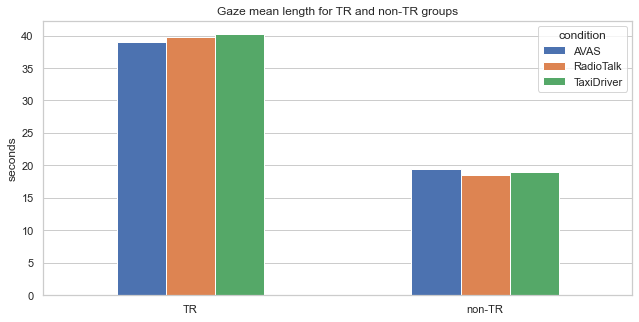

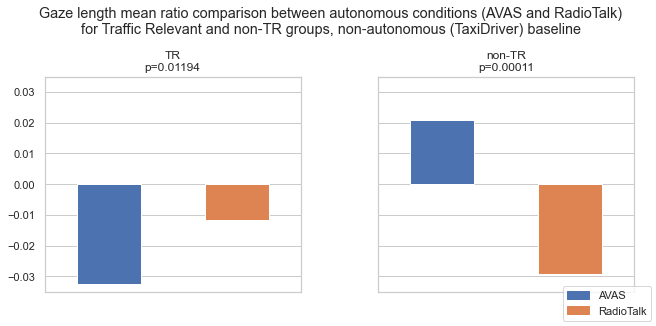

📄 0 of 2 📂 groups processed:                                                                                  …

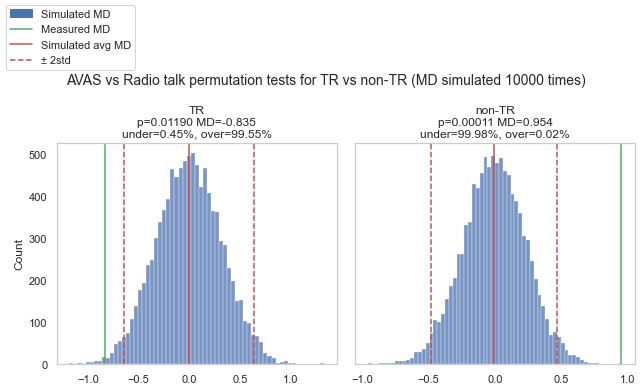

In [19]:
# mean plots
fig, axes = plt.subplots(figsize=(9, 4.5))
fig.tight_layout()

ax = (
    gaze_ltr.groupby(["condition"]).mean().transpose().plot.bar(rot=0, ax=axes)
)

ax.set_ylabel("seconds")
ax.xaxis.grid(False)

plt.title("Gaze mean length for TR and non-TR groups")

plt.show()


# ratios barplots
NCOLS = 2

fig, axes = plt.subplots(ncols=NCOLS, figsize=(9, 4.5))
fig.suptitle(
    "Gaze length mean ratio comparison between autonomous conditions (AVAS and RadioTalk)\nfor Traffic Relevant and non-TR groups, non-autonomous (TaxiDriver) baseline\n"
)
fig.tight_layout()

groups = gaze_ltr.drop("condition", axis=1).columns

for i, grp in enumerate(groups):
    means = gaze_ltr.groupby(["condition"])[grp].mean()
    s = means / means.loc["TaxiDriver"] - 1
    s = s.loc[["AVAS", "RadioTalk"]]
    ax = s.transpose().plot.bar(rot=0, color=colors, ax=axes[i])
    # calculate p-value using Welch's t-test (assuming different variance)
    avas = gaze_ltr[gaze_ltr.condition == "AVAS"][grp]
    radio = gaze_ltr[gaze_ltr.condition == "RadioTalk"][grp]
    taxi = gaze_ltr[gaze_ltr.condition == "TaxiDriver"][grp]
    t_test = stats.ttest_ind(avas, radio, equal_var=True)
    if i != 0:
        ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel(None)
    ax.set_title(f"{grp}\np={t_test[1]:.5f}")
    ax.set_ylim(-0.035, 0.035)
    ax.set_xticks([])

avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
fig.legend(handles=[avas_patch, radio_patch], loc="lower right")
plt.subplots_adjust(wspace=0.3)
plt.show()


# permutation tests
# TR and non-TR groups
tr_grps = gaze_ltr.columns.difference(["condition"]).tolist()

# collect conditions indices
avas_idx = gaze_ltr[gaze_ltr.condition == "AVAS"].index.tolist()
radio_idx = gaze_ltr[gaze_ltr.condition == "RadioTalk"].index.tolist()
taxi_idx = gaze_ltr[gaze_ltr.condition == "TaxiDriver"].index.tolist()

# participants progress bar
grps_pbar = tqdm(
    iterable=tr_grps,
    total=len(tr_grps),
    desc="📂 groups",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
    leave=False,
)

N_PERMS = 10000

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(9, 5.5))
fig.suptitle(
    f"\n\n\n\nAVAS vs Radio talk permutation tests for TR vs non-TR (MD simulated {N_PERMS} times)",
    fontsize=14,
)

for i, g in enumerate(grps_pbar):
    # select group to test
    sel = gaze_ltr[g]
    # select values of each condition
    avas = sel.loc[avas_idx].values.tolist()
    radio = sel.loc[radio_idx].values.tolist()
    # do the permutation tests
    actual, stat, under = permutationTest(avas, radio, N_PERMS)
    # calculate p-value using Welch's t-test (assuming different variance)
    avas = gaze_ltr[gaze_ltr.condition == "AVAS"][g]
    radio = gaze_ltr[gaze_ltr.condition == "RadioTalk"][g]
    taxi = gaze_ltr[gaze_ltr.condition == "TaxiDriver"][g]
    t_test = stats.ttest_ind(avas, radio, equal_var=False)
    # prepare title, compute mean and std
    title = f"{g}\np={t_test[1]:.5f} MD={actual:.3f}\nunder={under:.2f}%, over={100.0 - under:.2f}%"
    std = np.std(stat)
    mean = np.mean(stat)
    # plot results
    ax = sns.histplot(data=stat, ax=axes[i], stat="count")
    ax.set_title(title)
    ax.grid(False)
    axes[i].axvline(actual, color="g")
    axes[i].axvline(mean, color="r")
    axes[i].axvline(mean - 2 * std, linestyle="--", color="r")
    axes[i].axvline(mean + 2 * std, linestyle="--", color="r")

fig.legend(
    handles=[simulated_patch, measured_patch, avg_patch, std_patch],
    loc="upper left",
)
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.show()

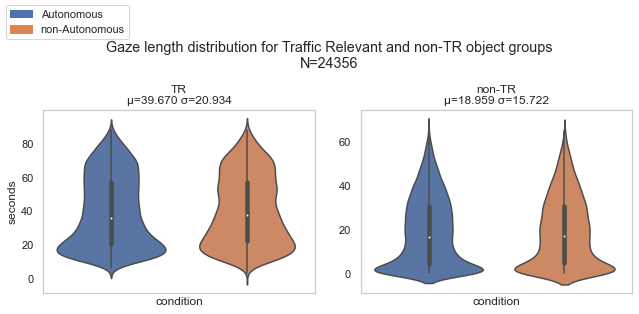

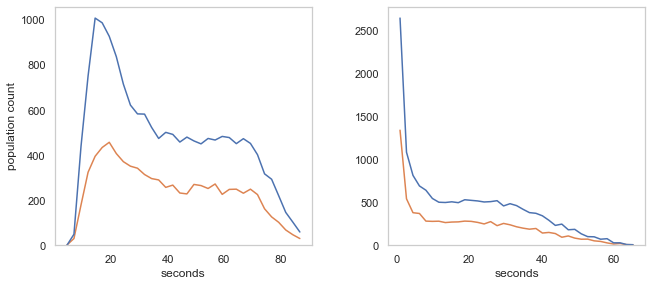

Autonomous 
 non-Autonomous 
 
 
 Gaze length variance 
   
   
 
 
 
 
 TR 
 445.822358 
 422.752109 
 
 
 non-TR 
 246.733518 
 248.075275 
 
 
 

 
 
 
   
 p-value (Bartlett) 
 Homoscedasticity 
 
 
 Homoscedasticity test 
   
   
 
 
 
 
 TR 
 0.005738 
 ❌ 
 
 
 non-TR 
 0.777280 
 ✔️ 
 
 
 

 
 
 
   
 Autonomous 
 non-Autonomous 
 Autonomous Normality 
 non-Autonomous Normality 
 
 
 Normality test 
   
   
   
   
 
 
 
 
 TR 
 0.000000 
 0.000000 
 ❌ 
 ❌ 
 
 
 non-TR 
 0.000000 
 0.000000 
 ❌ 
 ❌

In [20]:
gaze_aut = copy.deepcopy(gaze_ltr)
replacement = {
    "AVAS": "Autonomous",
    "RadioTalk": "Autonomous",
    "TaxiDriver": "non-Autonomous",
}
gaze_aut.condition = gaze_aut.condition.map(replacement)

groups = gaze_aut[gaze_aut.columns.difference(["condition"])].columns.tolist()
conds = sorted(gaze_aut.condition.unique().tolist())

# violin plots
NCOLS = 2
N = gaze_aut.index.size

fig, axes = plt.subplots(ncols=NCOLS, figsize=(9, 4.5))
fig.suptitle(
    f"\n\nGaze length distribution for Traffic Relevant and non-TR object groups\nN={N}\n"
)
fig.tight_layout()

for i, grp in enumerate(groups):
    mean = gaze_aut[grp].mean()
    std = gaze_aut[grp].std()
    title_extra = f"μ={mean:.3f} σ={std:.3f}"
    ax = sns.violinplot(
        data=gaze_aut,
        x="condition",
        y=grp,
        hue_order=conds,
        order=conds,
        ax=axes[i],
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.grid(False)
    ax.set_title(f"{grp}\n{title_extra}")
    if i == 0:
        ax.set_ylabel("seconds")
    ax.set_xlabel("condition")

auto_patch = mpatches.Patch(color=colors[0], label="Autonomous")
nauto_patch = mpatches.Patch(color=colors[1], label="non-Autonomous")
fig.legend(handles=[auto_patch, nauto_patch], loc="upper left")
plt.show()

# histograms
NCOLS = 2

fig, axes = plt.subplots(ncols=NCOLS, figsize=(9, 4))
# fig.suptitle(
#     "Gaze length distribution for Traffic Relevant and non-TR object groups"
# )
fig.tight_layout()

for i, grp in enumerate(groups):
    # s = normalize_series(gaze_aut[grp])
    ax = sns.histplot(
        data=gaze_aut,
        hue="condition",
        x=grp,
        # kde=True,
        # multiple="stack",
        element="poly",
        fill=False,
        ax=axes[i],
        legend=False,
        hue_order=conds,
        # stat="density",
    )
    # ax.set_xscale("log")
    ax.grid(False)
    if i == 0:
        ax.set_ylabel("population count")
    else:
        ax.set_ylabel(None)
    ax.set_xlabel("seconds")

plt.subplots_adjust(wspace=0.3)
plt.show()

# compute variance, check for normality and homoscedasticity
cond_var = pd.DataFrame(columns=conds)
for cond in conds:
    cond_var[cond] = gaze_aut[gaze_aut.condition == cond].var()
cond_var.index.name = "Gaze length variance"

# collect and display the variance of each group between conditions
shapiro = pd.DataFrame(columns=conds)
bartlett = pd.DataFrame(columns=["p-value (Bartlett)"])
for grp in groups:
    for cnd in conds:
        shapiro.loc[grp, cnd] = stats.shapiro(
            gaze_aut[gaze_aut.condition == cnd][grp]
        )[1]
    bartlett.loc[grp] = stats.bartlett(
        gaze_aut[gaze_aut.condition == "Autonomous"][grp],
        gaze_aut[gaze_aut.condition == "non-Autonomous"][grp],
    )[1]
for cnd in conds:
    check = shapiro[cnd] > 0.05
    check = ["✔️" if c == True else "❌" for c in check]
    shapiro[f" {cnd} Normality"] = check
shapiro.index.name = "Normality test"


check = bartlett["p-value (Bartlett)"] > 0.05
check = ["✔️" if c == True else "❌" for c in check]
bartlett["Homoscedasticity"] = check
bartlett.index.name = "Homoscedasticity test"


tables_joint = ""
df = cond_var.style.set_table_attributes("style='display:inline'")
tables_joint += df._repr_html_()
df = bartlett.style.set_table_attributes("style='display:inline'")
tables_joint += df._repr_html_()
df = shapiro.style.set_table_attributes("style='display:inline'")
tables_joint += df._repr_html_()

display_html(tables_joint, raw=True)

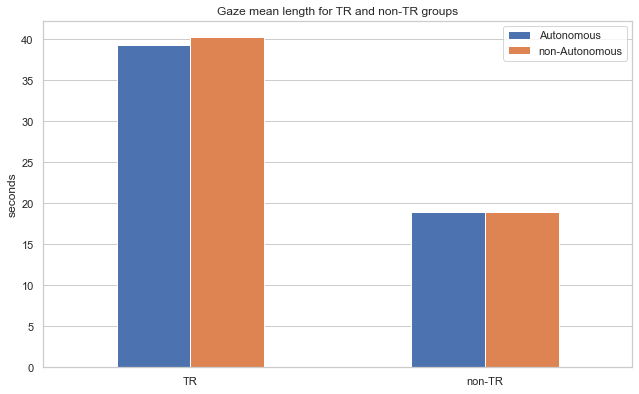

📄 0 of 2 📂 groups processed:                                                                                  …

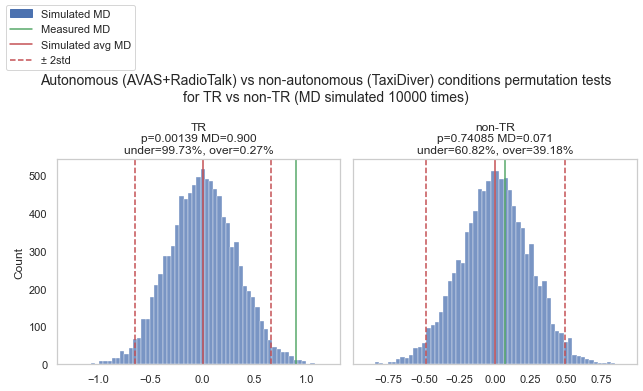

In [21]:
# mean plots
fig, axes = plt.subplots(figsize=(9, 5.5))
fig.tight_layout()

means = gaze_ltr.groupby(["condition"]).mean()

df = pd.DataFrame()
df["non-Autonomous"] = means.loc["TaxiDriver"]
df["Autonomous"] = (means.loc["AVAS"] + means.loc["RadioTalk"]) / 2

# order cols alphabetically
cols = sorted(df.columns.tolist())
df = df.reindex(columns=cols)

ax = df.plot.bar(rot=0, ax=axes)

ax.set_ylabel("seconds")
ax.xaxis.grid(False)

plt.title("Gaze mean length for TR and non-TR groups")

plt.show()

# permutation tests
# TR and non-TR groups
tr_grps = gaze_ltr.columns.difference(["condition"]).tolist()

# collect conditions indices
avas_idx = gaze_ltr[gaze_ltr.condition == "AVAS"].index.tolist()
radio_idx = gaze_ltr[gaze_ltr.condition == "RadioTalk"].index.tolist()
taxi_idx = gaze_ltr[gaze_ltr.condition == "TaxiDriver"].index.tolist()

# participants progress bar
grps_pbar = tqdm(
    iterable=tr_grps,
    total=len(tr_grps),
    desc="📂 groups",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
    leave=False,
)

N_PERMS = 10000

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(9, 5.5))
fig.suptitle(
    f"\n\n\n\nAutonomous (AVAS+RadioTalk) vs non-autonomous (TaxiDiver) conditions permutation tests\nfor TR vs non-TR (MD simulated {N_PERMS} times)",
    fontsize=14,
)

for i, g in enumerate(grps_pbar):
    # select group to test
    sel = gaze_ltr[g]
    # select values of each condition
    avas = sel.loc[avas_idx].values.tolist()
    radio = sel.loc[radio_idx].values.tolist()
    taxi = sel.loc[taxi_idx].values.tolist()
    # combine avas + radio (autonomous conditions)
    autonomous = avas + radio
    # do the permutation tests
    actual, stat, under = permutationTest(taxi, autonomous, N_PERMS)
    # calculate p-value using Welch's t-test (assuming different variance)
    autonomous = gaze_ltr[
        (gaze_ltr.condition == "AVAS") | (gaze_ltr.condition == "RadioTalk")
    ][g]
    taxi = gaze_ltr[gaze_ltr.condition == "TaxiDriver"][g]
    # autonomous.index.size
    t_test = stats.ttest_ind(autonomous, taxi, equal_var=False)
    # prepare title, compute mean and std
    title = f"{g}\np={t_test[1]:.5f} MD={actual:.3f}\nunder={under:.2f}%, over={100.0 - under:.2f}%"
    std = np.std(stat)
    mean = np.mean(stat)
    # plot results
    ax = sns.histplot(data=stat, ax=axes[i], stat="count")
    ax.set_title(title)
    ax.grid(False)
    axes[i].axvline(actual, color="g")
    axes[i].axvline(mean, color="r")
    axes[i].axvline(mean - 2 * std, linestyle="--", color="r")
    axes[i].axvline(mean + 2 * std, linestyle="--", color="r")

fig.legend(
    handles=[simulated_patch, measured_patch, avg_patch, std_patch],
    loc="upper left",
)
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.show()

__MANOVA: 'Buildings + CarsandPedestrians + InsideCar + Nature + Roads + StreetObjects + TrafficSigns ~ condition'__

In [22]:
groups = gaze_len.describe().columns.tolist()
gaze_lman = copy.deepcopy(gaze_len)

grp_conversion = {g: g.replace(" ", "") for g in groups}
gaze_lman = gaze_lman.rename(columns=grp_conversion)
simple_grps = list(grp_conversion.values())
display(simple_grps)
display(gaze_lman)

['Buildings',
 'CarsandPedestrians',
 'InsideCar',
 'Nature',
 'Roads',
 'StreetObjects',
 'TrafficSigns']

,Buildings,CarsandPedestrians,InsideCar,Nature,Roads,StreetObjects,TrafficSigns,condition
4f583872ffed48249874b00f3d389cfc,18.414,2.046,1.881,3.597,18.282,1.155,13.332,TaxiDriver
33d68ad55ef544fab9fd08108e3913ca,0.000,0.594,28.677,0.297,30.360,0.363,4.620,AVAS
8598a83e2af441b8bcd0ae5d84beb875,38.313,0.000,0.627,0.924,0.000,0.363,9.207,RadioTalk
37d7e67934974217830bb429bba7fd76,17.259,3.630,4.719,5.049,1.452,2.013,18.777,AVAS
42bac596059749b5b8e8e83ae61de9b4,34.584,0.000,0.528,6.402,0.000,2.310,10.362,TaxiDriver
...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,34.056,0.000,6.435,2.739,0.000,1.023,8.382,AVAS
611d35a7c3e940cc82495e53c2a8532d,19.041,0.000,24.288,4.686,2.838,1.056,9.537,TaxiDriver
3b6fda285d9e412eb081986b2f22a2e3,7.821,0.462,18.381,0.660,16.599,6.996,5.577,AVAS
18ffb0abdc8642098c479380bfa533d1,14.718,0.264,5.478,4.950,6.402,1.485,12.045,RadioTalk


In [23]:
formula = " + ".join(simple_grps)
formula += " ~ condition"
display(formula)

# fit manova
manova_result = MANOVA.from_formula(formula, gaze_lman)
df_manova = manova_result.mv_test().summary_frame
display(df_manova)

'Buildings + CarsandPedestrians + InsideCar + Nature + Roads + StreetObjects + TrafficSigns ~ condition'

Value Num DF    Den DF   F Value Pr > F
Effect    Statistic                                                      
Intercept Wilks' lambda           0.066      7 24347.000 49334.565  0.000
          Pillai's trace          0.934  7.000 24347.000 49334.565  0.000
          Hotelling-Lawley trace 14.184      7 24347.000 49334.565  0.000
          Roy's greatest root    14.184      7     24347 49334.565  0.000
condition Wilks' lambda           0.988     14 48694.000    20.779  0.000
          Pillai's trace          0.012 14.000 48696.000    20.740  0.000
          Hotelling-Lawley trace  0.012     14 38951.840    20.817  0.000
          Roy's greatest root     0.011      7     24348    37.419  0.000

P values

In [24]:
pd.options.display.float_format = "{:.2g}".format
p_vals = pd.DataFrame(columns=["Pr > F"])
tests = [
    "Wilks' lambda",
    "Pillai's trace",
    "Hotelling-Lawley trace",
    "Roy's greatest root",
]

for t in tests:
    p_vals.loc[t] = df_manova.loc[("condition", t)]["Pr > F"]

display(p_vals)

,Pr > F
Wilks' lambda,1.4e-53
Pillai's trace,1.8e-53
Hotelling-Lawley trace,1.2e-53
Roy's greatest root,1.6e-52


__MANOVA's post-hoc test__

Prior probabilities of groups:


array([0.33876663, 0.32468386, 0.33654952])

Group means:


array([[15.51117986,  0.75192886, 19.33932784,  2.67851133, 11.23844976,
         1.21268901,  7.62859932],
       [14.69710584,  0.70903263, 19.97415554,  2.55974924, 11.72756487,
         1.1911047 ,  7.38283612],
       [15.24922472,  0.68353922, 22.29997645,  2.5812224 , 10.10709442,
         1.17542723,  7.17598829]])

Coefficients of linear discriminants:


array([[ 0.08990864,  0.06882243],
       [ 0.25846108,  0.37648978],
       [ 0.07818017,  0.0265783 ],
       [ 0.01789473,  0.00692712],
       [ 0.00648752,  0.0132627 ],
       [ 0.07487105, -0.19474025],
       [-0.07023442,  0.16224731]])

Variance explained by each of the selected components:


array([0.89868923, 0.10131077])

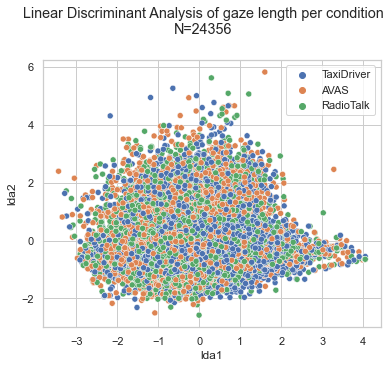

In [25]:
# target, outcome, label, dependent variable
target = "condition"
# predictor, attribute, independent variable, input, regressor, covariate
features = sorted(gaze_lman.columns.difference([target]))
# each row (features and target) is an observation

X = gaze_lman[features]
y = gaze_lman[target]
post_hoc = lda().fit(X=X, y=y)

# get Prior probabilities of groups:
print("Prior probabilities of groups:")
display(post_hoc.priors_)

# get group means
print("Group means:")
display(post_hoc.means_)

# get Coefficients of linear discriminants
print("Coefficients of linear discriminants:")
display(post_hoc.scalings_)

# get Proportion of trace (variance explained by each of the selected components)
print("Variance explained by each of the selected components:")
display(post_hoc.explained_variance_ratio_)

# plot
X_new = pd.DataFrame(
    lda().fit(X=X, y=y).transform(X), columns=["lda1", "lda2"]
)
X_new["condition"] = gaze_lman["condition"]

# violin plots
N = gaze_lman.index.size

fig, axes = plt.subplots(figsize=(5.5, 5))
fig.suptitle(
    f"Linear Discriminant Analysis of gaze length per condition\nN={N}"
)
fig.tight_layout()

sns.scatterplot(
    data=X_new, x="lda1", y="lda2", hue=gaze_lman.condition.tolist(), ax=axes
)
plt.show()

In [26]:
gaze_lman_mod = copy.deepcopy(gaze_lman)
display(gaze_lman_mod.iloc[0])

coeffs = post_hoc.coef_.tolist()
display(coeffs)

conds = post_hoc.classes_.tolist()
display(conds)

feats = post_hoc.feature_names_in_.tolist()
display(feats)

super_ind = []
ind_vars = gaze_lman.columns.difference(["condition"])
for part in gaze_lman.index.tolist():
    cur = gaze_lman.loc[part]
    cond = cur.condition
    c = conds.index(cond)
    svar = sum([cur[dvar] * coeffs[c][i] for i, dvar in enumerate(feats)])
    super_ind.append(svar)

gaze_lman_mod["SuperVar"] = super_ind
display(gaze_lman_mod)

Buildings                     18
CarsandPedestrians             2
InsideCar                    1.9
Nature                       3.6
Roads                         18
StreetObjects                1.2
TrafficSigns                  13
condition             TaxiDriver
Name: 4f583872ffed48249874b00f3d389cfc, dtype: object

[[-0.002841193074483318,
  -0.0003968446041887045,
  -0.003917588777747943,
  -0.0008600062123129716,
  0.00015587956874050455,
  -0.013329796515780631,
  0.011615506054542115],
 [-0.010326829307884105,
  -0.037156223295190124,
  -0.007588760161528176,
  -0.0017722708573661614,
  -0.0010920563303419882,
  0.001939285226981765,
  -0.0009648331093392358],
 [0.012822648557314768,
  0.036245672642128114,
  0.011264601727773925,
  0.002575457996565314,
  0.0008966474489040546,
  0.01154669799642963,
  -0.010761210226591664]]

['AVAS', 'RadioTalk', 'TaxiDriver']

['Buildings',
 'CarsandPedestrians',
 'InsideCar',
 'Nature',
 'Roads',
 'StreetObjects',
 'TrafficSigns']

,Buildings,CarsandPedestrians,InsideCar,Nature,Roads,StreetObjects,TrafficSigns,condition,SuperVar
4f583872ffed48249874b00f3d389cfc,18,2,1.9,3.6,18,1.2,13,TaxiDriver,0.23
33d68ad55ef544fab9fd08108e3913ca,0,0.59,29,0.3,30,0.36,4.6,AVAS,-0.059
8598a83e2af441b8bcd0ae5d84beb875,38,0,0.63,0.92,0,0.36,9.2,RadioTalk,-0.41
37d7e67934974217830bb429bba7fd76,17,3.6,4.7,5,1.5,2,19,AVAS,0.12
42bac596059749b5b8e8e83ae61de9b4,35,0,0.53,6.4,0,2.3,10,TaxiDriver,0.38
...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,34,0,6.4,2.7,0,1,8.4,AVAS,-0.041
611d35a7c3e940cc82495e53c2a8532d,19,0,24,4.7,2.8,1.1,9.5,TaxiDriver,0.44
3b6fda285d9e412eb081986b2f22a2e3,7.8,0.46,18,0.66,17,7,5.6,AVAS,-0.12
18ffb0abdc8642098c479380bfa533d1,15,0.26,5.5,5,6.4,1.5,12,RadioTalk,-0.23


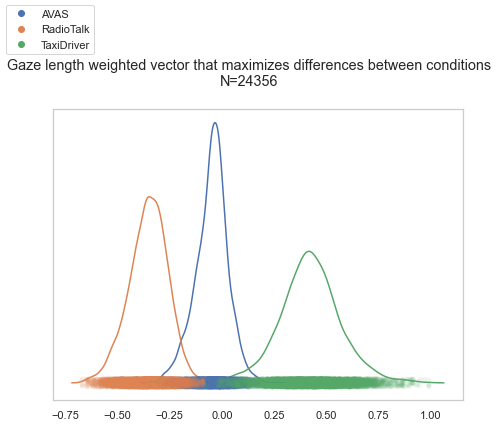

In [27]:
# violin plots
N = gaze_lman_mod.index.size

fig, axes = plt.subplots(figsize=(6.5, 6))
fig.suptitle(
    f"\n\n\nGaze length weighted vector that maximizes differences between conditions\nN={N}"
)
fig.tight_layout()

palette = itertools.cycle(sns.color_palette(palette="deep"))
for c in conds:
    color = next(palette)
    cur = gaze_lman_mod[gaze_lman_mod.condition == c]
    ax = sns.stripplot(data=cur, x="SuperVar", color=color, alpha=0.1, ax=axes)
    ax.grid(False)
    ax.set_xlabel(None)

    ax = sns.kdeplot(data=cur, x="SuperVar", color=color)
    ax.grid(False)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

avas_patch = Line2D(
    [],
    [],
    marker="o",
    color=colors[0],
    label="AVAS",
    linestyle="None",
)
radio_patch = Line2D(
    [],
    [],
    marker="o",
    color=colors[1],
    label="RadioTalk",
    linestyle="None",
)
taxi_patch = Line2D(
    [],
    [],
    marker="o",
    color=colors[2],
    label="TaxiDriver",
    linestyle="None",
)

fig.legend(handles=[avas_patch, radio_patch, taxi_patch], loc="upper left")
plt.gca().invert_yaxis()
plt.show()